In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import copy

import pyPSFstack
import pyPSFstack.pupils.sources as sources
import pyPSFstack.pupils.windows as windows
import pyPSFstack.pupils.aberrations as aberrations
from pyPSFstack.diversities.pupil_diversities import ZDiversity
import pyPSFstack.diversities.pola_diversities as pola_diversities
from pyPSFstack.functions import trim_stack

import torchPSFstack
import torchPSFstack.pupils.sources as torchsources
import torchPSFstack.pupils.windows as torchwindows
import torchPSFstack.pupils.aberrations as torchaberrations
from torchPSFstack.diversities.pupil_diversities import torchZDiversity
import torchPSFstack.diversities.pola_diversities as torchpola_diversities
from torchPSFstack.functions import get_pupils_param_dict, get_normNbck

# torchPSFstack: Example of use 

## 1. Simulate experimental data using pyPSFstack

### 1.1. Parameter definition

In [3]:
# Define number of points use for the computation 
N_pts = 128
# Experimental parameters
numerical_aperture = 1.49
magnification = 100
ni = 1.33
nf = 1.515
cam_pixel_size = 6500
radius = 10
wavelength = 605
dipole_orientation = [0,0,0] # this means incoherent
# Define positions of defocus
zi = -500; zf = 500; z_step = 100
z_list = np.arange(zi,zf+z_step,z_step)
# Define rotation angles for the polarization analyzer
angle_i = 0; angle_f = np.pi/2; angle_step = np.pi/8
angle_list=np.arange(angle_i,angle_f,angle_step)
# number of slices used to compute the exact blurring
blurring_slices = 10

Put all necessary parameters in dicts

In [4]:
params = {}
params['pupil'] = {}
params['pupil']['aperture_size'] = numerical_aperture / nf
params['pupil']['computation_size'] = wavelength*magnification/(cam_pixel_size*nf)
params['pupil']['N_pts'] = N_pts

params['source'] = {}
params['source']['ni'] = ni
params['source']['nf'] = nf
params['source']['delta'] = (radius + np.random.rand()*20 )/wavelength

params['defocus'] = {}
params['defocus']['nf'] = nf
params['defocus']['delta_z'] =  (np.random.rand()-0.5)*50/wavelength

params['seo'] = {}
params['seo']['c'] = 1.25*np.pi

params['zdiversity'] = {}
params['zdiversity']['z_list'] = z_list / wavelength
params['zdiversity']['nf'] = nf

params['pdiversity'] = {}
params['pdiversity']['qwp_angles'] = angle_list
params['pdiversity']['lp_angles'] = [0,np.pi/2]

params['blurring'] = {}
params['blurring']['ni'] = ni
params['blurring']['nf'] = nf
params['blurring']['radius'] = radius/wavelength
params['blurring']['diff_del_list'] = np.linspace(-radius/wavelength,
    radius/wavelength,blurring_slices+2)[1:-1] 

### 1.2. Instantiate all necessary class elements

In [5]:
# The source and window define the pupil sequence
src = sources.DipoleInterfaceSource(**params['pupil'],**params['source'])
defocus = windows.Defocus(**params['pupil'],**params['defocus'])
seo = windows.SEO(**params['pupil'],**params['seo'])
pupil_sequence = [src, defocus, seo]

# Then the diversities
zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])
# The polarization diversity is taken as a rotating QWP followed 
# by a wollastan which splits into horizontal and vertical polarized
# light 
qwp = pola_diversities.PDiversity_QWP(angle_list)
wollaston = pola_diversities.PDiversity_LP([0, np.pi/2])
pdiv = pola_diversities.PDiversity_Compound([qwp, wollaston])

# Finally we define the blurring as the exact model to try
# to mimic the experimental result
blurring = pyPSFstack.blurring.ExactBlurring(**params['blurring'],**params['pupil'])

psfs = pyPSFstack.PSFStack(pupil_sequence, zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)


### 1.3. Compute the PSF stack

We compute the stack for an incoherent dipole

In [6]:
psfs.compute_psf_stack(orientation=[0,0,0])

Then we add the background illumination and noise

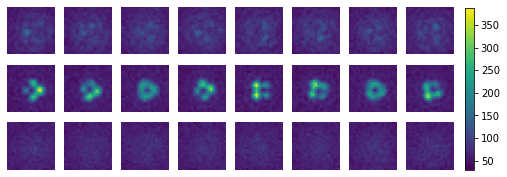

In [7]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=21,noise=True)
v_max = np.max(data_stack)
v_min = np.min(data_stack)

zdiv_mid_ind = int((zf-zi)/z_step//2)
fig, axs = plt.subplots(3,8,figsize=(8,3))
for ind in range(8):
    axs[0,ind].imshow(data_stack[...,0,ind],vmin=v_min,vmax=v_max)
    im = axs[1,ind].imshow(data_stack[...,zdiv_mid_ind,ind],vmin=v_min,vmax=v_max)
    axs[2,ind].imshow(data_stack[...,-1,ind],vmin=v_min,vmax=v_max)
for ax in axs.ravel():
    ax.set_axis_off()

cb_ax = fig.add_axes([0.92,0.125,0.015,0.75])
fig.colorbar(im, cax=cb_ax)

## 2. Birefringent pupil retrieval

### 2.1. Model definition

Define the parameters for the retrieval, we copy those used to simulate the data and simply change the values to which an error was added (distance to coverslip `delta` and defocus `delta_z`), and those for the aberrations.

In [8]:
params_ret = copy.deepcopy(params)

params_ret['source']['delta'] = radius/wavelength
params_ret['defocus']['delta_z'] = 0

#define the number of Polynomials used for each component of the 
#unitary pupil
params_ret['aberrations'] = {}
params_ret['aberrations']['jmax_list'] = [15]*4+[15]

Then we instantiate all necessary class elements

In [9]:
# Define all the source, window and defocus pupils 
tsrc = torchsources.torchDipoleInterfaceSource(**params_ret['pupil'], **params_ret['source'])
tdef = torchwindows.torchDefocus(**params_ret['pupil'],**params_ret['defocus']) # This incorporate a defocus term to the optimization
twdw = torchaberrations.torchUnitaryZernike(**params_ret['pupil'], **params_ret['aberrations'])
tpupil_sequence = [tsrc, tdef, twdw]

# Define the diversities
tzdiv = torchZDiversity(**params_ret['zdiversity'], **params_ret['pupil'])
tpdiv = torchpola_diversities.torchPDiversity_Compound(
    [torchpola_diversities.torchPDiversity_QWP(angle_list), 
     torchpola_diversities.torchPDiversity_LP([0, np.pi/2])])
     
# Put everything into an instance of torchPSFStack
model_retrieved = torchPSFstack.torchPSFStack(
                 data_stack.shape[0],
                 tpupil_sequence,
                 zdiversity=tzdiv,
                 pdiversity=tpdiv
                 )

Then, we use the model data to estimate the scaling factor and background illumination

In [10]:
# First we estimate the total number of photons in the PSFs
# and background illumination
data_norm, data_bck = get_normNbck(data_stack)

# Then we compute a first estimate using the torch model with no gradient computation
with torch.no_grad():
    model_retrieved.eval()
    first_est = model_retrieved()

# Using this first estimate we can set the overall scale factor 
model_retrieved.set_scale_factor(data_norm/torch.sum(first_est))

# We also initialize set the backgoround illumination and tell the model
# to include it in the optimization parameters
model_retrieved.set_pb_bck(data_bck, opt_b=True) # optimize background

### 2.2. Launch optimization

Set learning rate, and number of iterations

In [11]:
lr = 3e-2 # learning rate
n_epochs = 100 # number of iterations

# Define cost function sccording to the noise statistics
loss_fn = torchPSFstack.cost_functions.loss_loglikelihood

# instatiate an optimzer from several readily available from torch
# here Adam is used
optimizer = torch.optim.Adam(
    model_retrieved.parameters(), 
    lr=lr
)
# turn data into a torch tensor
data = torch.from_numpy(data_stack).type(torch.float)

Run optimization

100%|██████████| 100/100 [00:07<00:00, 13.18it/s]


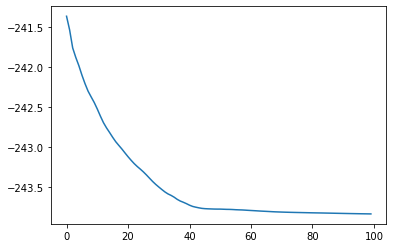

In [12]:
loss_evol =[]
for epoch in tqdm(range(n_epochs)):
    
    model_retrieved.train()
    stack_modeled = model_retrieved()
    
    loss = loss_fn(stack_modeled, data)
    loss_evol += [loss.item()] # add loss to list 
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()

plt.plot(loss_evol)

## 3. Comparrison

### 3.1. PSFstack

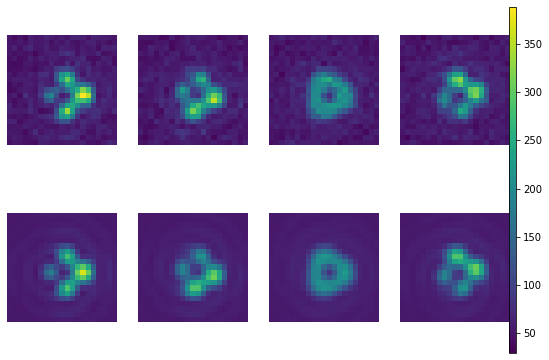

In [13]:
zdiv_mid_ind = int((zf-zi)/z_step//2) # mid point should be in focus psf
ret_stack = stack_modeled.detach() # get retrieved stack

fig, ax = plt.subplots(2,4,figsize=(9,6))
for ind in range(4):
    im = ax[0,ind].imshow(data_stack[...,zdiv_mid_ind-1,ind],vmin=v_min,vmax=v_max)
    ax[0,ind].set_axis_off()
    ax[1,ind].imshow(ret_stack[...,zdiv_mid_ind-1,ind],vmin=v_min,vmax=v_max)
    ax[1,ind].set_axis_off()
cb_ax = fig.add_axes([0.9,0.1,0.01,0.8])
fig.colorbar(im, cax=cb_ax)

### 3.2 Birefringent pupil

We retrieve the parameters of the aberrations mask found during the optimization and instantiate the corresponding class element of ``pyPSFstack`` for easy handling and plotting

Use the `get_pupils_param_dict` function to extract all the parameters from the torch model as a dictionnary:

In [14]:
ret_pupil_params = get_pupils_param_dict(model_retrieved)
ret_pupil_params.keys()

dict_keys(['pupil0', 'pupil1', 'pupil2', 'pb_bck'])

The widow we wanted to retrieve in 'pupil2', we can use it paramters to define a pupil using `pyPSFstack` as follows:

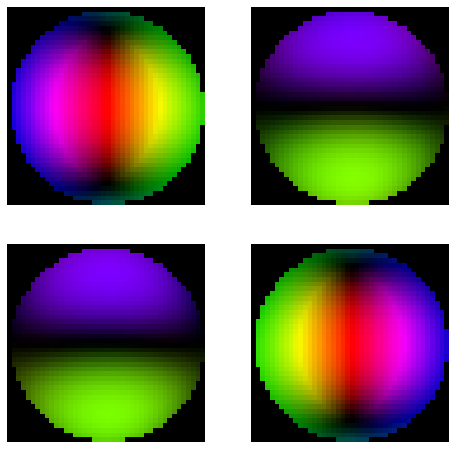

In [16]:
abe = aberrations.UnitaryZernike(**params['pupil'], 
     **ret_pupil_params['pupil2'])
abe.plot_pupil_field()

Compare to the defined mask

c:\Users\Rodrigo.SAOPAULO\Documents\Research\pyPSFstack\pyPSFstack\pupil.py:147: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


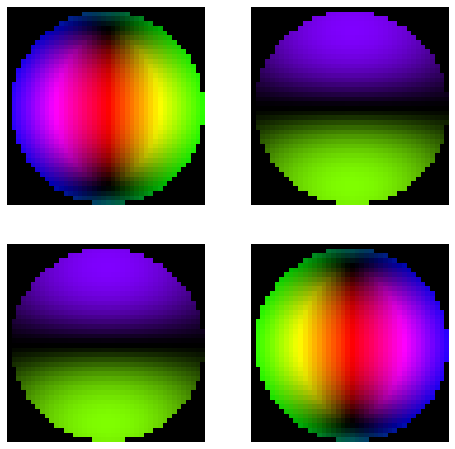

In [18]:
seo.plot_pupil_field()